In [1]:
import tensorflow as tf
from keras.models import model_from_json
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from tqdm import tqdm
import copy
import glob
import random
from collections import defaultdict

Using TensorFlow backend.


In [2]:
def load_model(nn_path):
    json_file = open(nn_path.format('.json'),'r')
    data = json_file.read()
    json_file.close()

    model = model_from_json(data,custom_objects = {'tf':tf})
    model.load_weights(nn_path.format('.h5'))
    return model

In [3]:
NUM_FRAMES = 12

def getvideoname(name):
    return '_'.join(name.split('\\')[-1].split('_')[:3])

def getframe(name):
    return name.split('\\')[-1].split('_')[-1].split('.')[0]

def getlabel(name):
    if len(name.split('\\')[-1].split('_'))>=5:
        try:
            return [float(x) for x in name.split('\\')[-1].split('_')[3:-1]]
        except:
            return [0,0,0]
    else:
        return [0,0,0]

def getfoldername(path):
    return path.split('\\')[-2]

def getprepath(path):
    return '\\'.join(path.split('\\')[:-2])

def load_data(data_path):
    np_files = glob.glob(data_path)
    data_list = []
    labels_list = []
    og_path = getprepath(data_path)
    num_files = len(np_files)
    num_frames_total = 0

    for i in range(num_files):
        try:
            f = np_files[i]
            if 'label' in f:
                continue
            folder = getfoldername(f)
            key = getvideoname(f)

            full_path = '\\'.join([og_path,folder,key])
            video = np.load(full_path + '_video.npy')
            labels = np.load(full_path + '_label.npy')

            num_samples = video.shape[0]//NUM_FRAMES*NUM_FRAMES
            videos = video[:num_samples]
            labels = labels[:num_samples][0::NUM_FRAMES]
            data_list.extend(videos)
            labels_list.extend(labels)
            num_frames_total += num_samples
        except:
            continue
    
    assert(num_frames_total // NUM_FRAMES == num_frames_total/NUM_FRAMES)
    indexes=[x for x in range(num_frames_total//NUM_FRAMES)]
    random.shuffle(indexes)
    return indexes,data_list,labels_list

def unnorm(preds):
    high = 4.47296
    low = -3.26233
    for i in range(len(preds)):
        preds[i] = (high-low)*preds[i] + low
    return preds

In [14]:
# load the models from the paths to each results folder

# names of the results folders to be loaded
names = [ '2x2dcnn_lstm_classify_3' ]
# path to results
path = r'C:\Users\Chris\Documents\projects\cs172b\project\172Bproj\results'
          
models = []
for name in names:
    models.append(load_model(path+'\\{}\\MobileNetV2'.format(name,name)+'{}'))

In [19]:
# load data from 1 video
# raw_data = np.load( r'C:\Users\Chris\Documents\projects\cs172b\01_3m_r\01_3min_rest_cheek.npy' )
# labels = np.load( r'C:\Users\Chris\Documents\projects\cs172b\01_3m_r\01_3min_rest_peak.npy' )

raw_data = np.load( r'C:\Users\Chris\Documents\projects\cs172b\aicure-dataset\01_4m_p\01_4min_post_cheek.npy' )
labels = np.load( r'C:\Users\Chris\Documents\projects\cs172b\aicure-dataset\01_4m_p\01_4min_post_peak.npy' )

# raw_data = np.load( r'C:\Users\Chris\Documents\projects\cs172b\aicure-dataset\29_4m_r\29_4min_rest_cheek.npy' )
# labels = np.load( r'C:\Users\Chris\Documents\projects\cs172b\aicure-dataset\29_4m_r\29_4min_rest_peak.npy' )
#labels = labels[::12] # get every 12th label   

# retrieve labels
print(raw_data.shape)
print(labels.shape)

(2880, 224, 224, 3)
(2880, 1)


In [20]:
raw_predictions = [ [] for _ in range(len(models)) ]

in_shapes = [ m.input_shape for m in models ]

# format the data such that predictions are made on batches of NUM_FRAMES
data = []
it = iter(raw_data)
for frame in it:
    d = [frame]
    for _ in range( NUM_FRAMES - 1 ):
        d.append(next(it))
    data.append(np.array(d))

# make predictions
# for i in range(len(models)):
#     for batch in tqdm(data,ncols=80):
#         raw_predictions[i].extend( models[i].predict(np.array([batch])) ) # np.array([batch])
        
# make predictions (2x2D CNN):
# for i in range(len(models)):
#     for batch in tqdm(data,ncols=80):
#         x1,x2,x3,x4,x5 = batch
#         raw_predictions[i].extend( 
#             models[i].predict(
#                 {'input0' : np.array([x1]),
#                  'input1' : np.array([x2]),
#                 'input2' : np.array([x3]),
#                 'input3' : np.array([x4]),
#                 'input4' : np.array([x5]),}
#             ) 
#         )

#
for i in range(len(models)):
    for batch in tqdm(data,ncols=80):
        x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11 = batch
        raw_predictions[i].extend( 
            models[i].predict(
                { 'input0': np.array([x0]), 
                    'input1': np.array([x1]),
                    'input2': np.array([x2]),
                    'input3': np.array([x3]),
                    'input4': np.array([x4]),
                    'input5': np.array([x5]), 
                    'input6': np.array([x6]),
                    'input7': np.array([x7]),
                    'input8': np.array([x8]),
                    'input9': np.array([x9]),
                    'input10': np.array([x10]), 
                    'input11': np.array([x11])}
            ) 
        )



predictions = [ [] for _ in range(len(models)) ]
for i in range(len(raw_predictions)):
    for j in range(len(raw_predictions[i])):
        predictions[i].extend( raw_predictions[i][j].flatten() )
    
# FOR OLD MODELS
# try to find a way to get input layer dimensions and input dimensions
# for i in range(len(models)):
#     for video in data:
#         try:
#             for j in tqdm(range(len(video)-1),ncols=80): # 2-input models 
#                 x1 = [video[j]]
#                 x2 = [video[j+1]]
                
#                 predictions[i].append( 
#                     models[i].predict( 
#                         {'input1' : np.array(x1), 
#                          'input2' : np.array(x2)} 
#                 ))
                
#         except ValueError:
#             for j in tqdm(range(len(video)-2),ncols=80): # 3-input models
#                 x1 = [open_img(video[j] ,(540,540,3) )]
#                 x2 = [open_img(video[j+1] ,(540,540,3) )]
#                 x3 = [open_img(video[j+2] ,(540,540,3) )]

#                 predictions[i].append( 
#                     models[i].predict( 
#                         {'input1' : np.array(x1), 
#                          'input2' : np.array(x2),
#                          'input3' : np.array(x3)} 
#                 ))

100%|█████████████████████████████████████████| 240/240 [00:10<00:00, 22.32it/s]


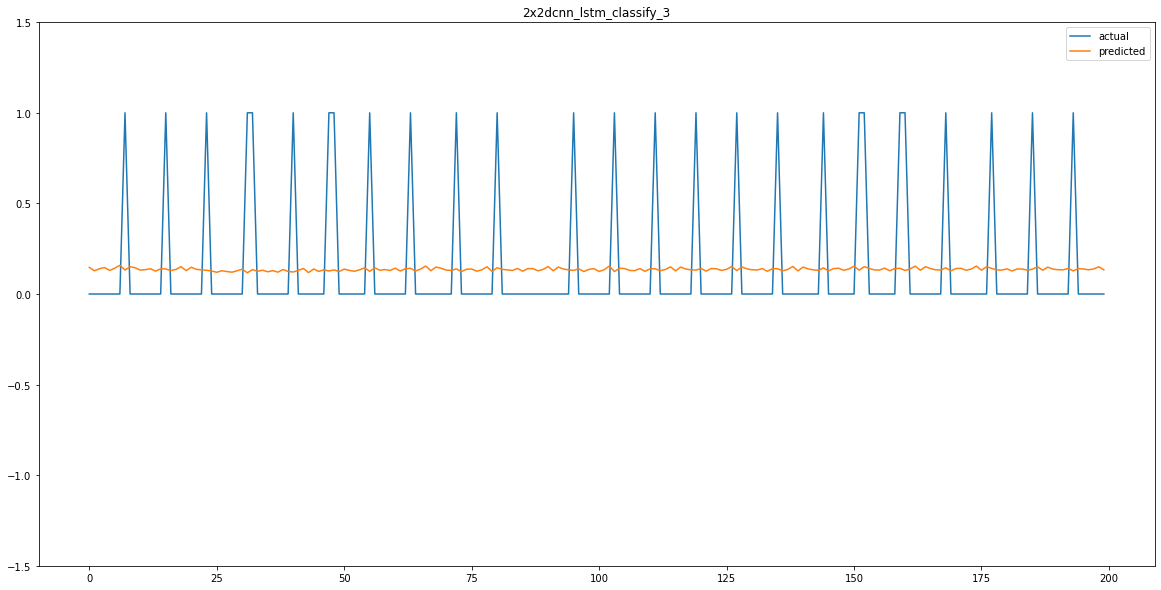

In [21]:
# graph results
 
nsamples = 200 # needs to be less than len(predictions[0])
if nsamples > labels.shape[0]:
    nsamples = labels.shape[0]
times = np.arange(len(predictions[0]))[:nsamples]

# unnormalized (if needed)
# for i in range(len(predictions)):
#     predictions[i] = unnorm(predictions[i])

if len(models) > 1:
    fig,axs = plt.subplots(len(models),figsize=(20,20))
    for idx,ax in enumerate(axs):
        ax.set_title(names[idx])
        ax.plot(times,labels[:nsamples],label = 'actual')
        ax.plot(times,[x for x in predictions[idx]][:nsamples],label = 'predicted')
        ax.legend()
    plt.show()
else:
    plt.figure(figsize=(20,10))
    plt.title(names[0])
    plt.ylim(top=1.5,bottom=-1.5)
    plt.plot(times,[x for x in labels][:nsamples],label = 'actual')
    plt.plot(times,[x for x in predictions[0]][:nsamples],label = 'predicted')
    plt.legend()
    plt.show()

In [12]:
np_files = glob.glob(r'C:\Users\Chris\Documents\projects\cs172b\aicure-dataset\*\*_label.npy')
datapts = 0
for f in np_files:
    labels = np.load(f)
    datapts += labels.shape[0]
print(datapts)

174381


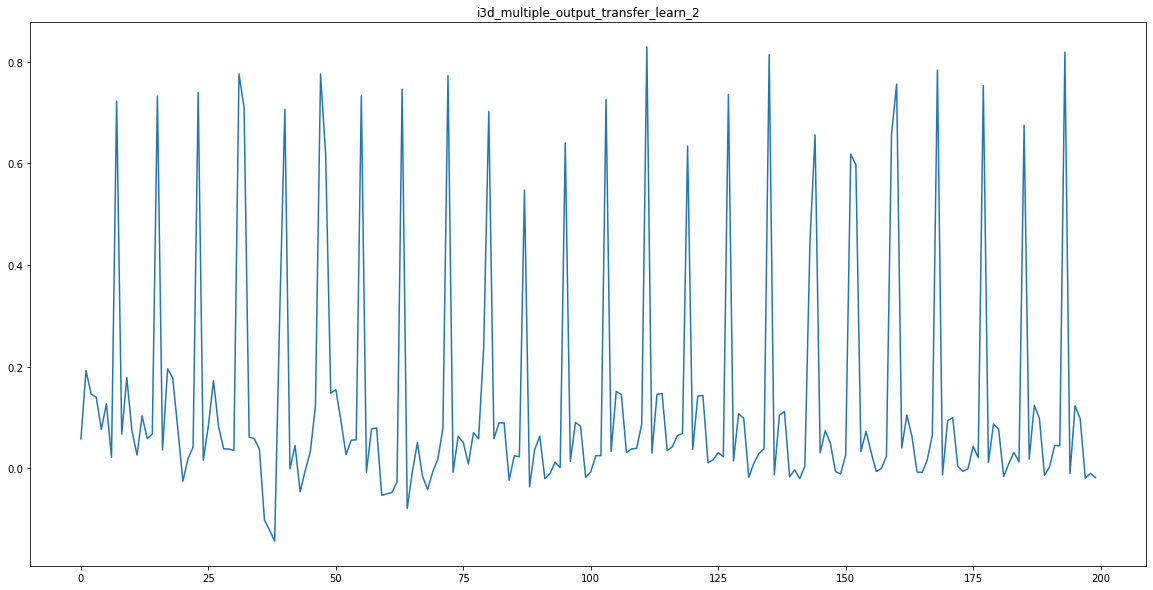

In [9]:
plt.figure(figsize=(20,10))
plt.title(names[0])
plt.plot(times,[x[0] for x in labels][:nsamples],label = 'actual')
#plt.plot(times,[x for x in predictions[0]][:nsamples],label = 'predicted')

In [19]:
[x[0] for x in labels]

[0.0578308,
 0.192261,
 0.146027,
 0.139923,
 0.0764465,
 0.127106,
 0.0215149,
 0.7226560000000001,
 0.0669861,
 0.178375,
 0.0740051,
 0.0259399,
 0.103149,
 0.058288599999999996,
 0.0674438,
 0.732422,
 0.0363159,
 0.19577,
 0.17791700000000002,
 0.078125,
 -0.0253296,
 0.018768299999999998,
 0.0416565,
 0.739441,
 0.0157166,
 0.0836182,
 0.172729,
 0.08193969999999999,
 0.038299599999999996,
 0.0378418,
 0.0352478,
 0.776062,
 0.7096859999999999,
 0.061492899999999996,
 0.058136,
 0.038147,
 -0.10192899999999999,
 -0.12176500000000001,
 -0.14328,
 0.30593899999999996,
 0.7064819999999999,
 -0.0012207000000000001,
 0.0447083,
 -0.0462341,
 -0.00442505,
 0.032958999999999995,
 0.122223,
 0.775909,
 0.616913,
 0.147705,
 0.154724,
 0.09353639999999999,
 0.026702899999999998,
 0.0550842,
 0.0559998,
 0.73288,
 -0.00747681,
 0.0773621,
 0.0793457,
 -0.053405799999999996,
 -0.0502014,
 -0.0476074,
 -0.0273132,
 0.746002,
 -0.0791931,
 -0.00732422,
 0.050354,
 -0.0158691,
 -0.0419617,
 -0

In [12]:
def s(z):
    return float(1) / (1+np.exp(-z))

In [15]:
for x in range(len(predictions[0])):
    predictions[0][x] = s(predictions[0][x])

In [22]:
np.save('{}.npy'.format(names[0]),predictions[0])